# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [92]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [93]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [94]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9851 / 11441 MB available


In [127]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int nbCols) {
    unsigned int iX = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int iY = blockIdx.y*blockDim.y + threadIdx.y;
    unsigned int position = iY*nbCols + iX;
    
    c[position] = a[position] + b[position];
}

__global__ void mulMatrixKernel(float* c, float* a, float* b, int nbRows, int nbCols) {
    unsigned int iY = blockIdx.y*blockDim.y + threadIdx.y;
    unsigned int position;
    unsigned int inc;

    float sum = 0.0f;
    for (inc=0; inc<nbCols; inc++) {
      position = iY*nbCols + inc;
      sum += a[position]*b[inc];
    }
    
    //c[iY] = sum;
    c[iY] = iY;
}

"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("mulMatrixKernel");

<bound method Figure.show of <matplotlib.figure.Figure object at 0x7f474212cda0>>

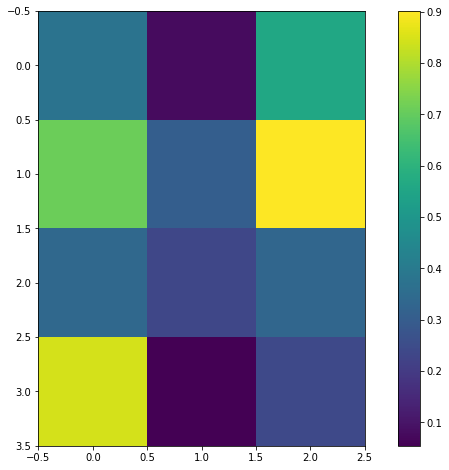

In [128]:
#Size of our test
test_size = (4,3)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random((3,1)).astype(np.float32)
c = np.empty((4,1))

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
fig.show

In [129]:
print(a.shape)

(4, 3)


In [130]:
print(b.shape)
print(c.shape)

(3, 1)
(4, 1)


In [131]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [132]:
print(a.shape)
print(b.shape)
print(c.shape)

(4, 3)
(3, 1)
(4, 1)


In [133]:
#a.shape = [rows, columns] => [y,x]
domain_size = (a.shape[1], a.shape[0])

#iX = 1, iY = number of rows in A
block_size = (1,1,1)
grid_size = (1, c.shape[0], 1)

print("Domain size is " + str(domain_size))
print("Block size is " + str(block_size))
print("grid size is " + str(grid_size))

Domain size is (3, 4)
Block size is (1, 1, 1)
grid size is (1, 4, 1)


In [134]:
print(a.shape)

(4, 3)


In [137]:
kernel(c_g, a_g, b_g, np.int32(a.shape[0]),np.int32(a.shape[0]), block=block_size, grid=grid_size)

In [138]:
#Copy data from device to host
c_g.get(c)

TypeError: self and ary must have the same dtype

In [124]:
print(test_size)
print(a.shape)

(4, 3)
(4, 3)


In [126]:
#Compute reference using Numpy
c_ref = np.empty((4,1))
for i in range(test_size[0]):
    c_ref[i] = 0
    for j in range(test_size[1]):
        c_ref[i] += a[i][j]*b[j]
        print("c_ref   i : ",i," val : ",c_ref[i])

c_ref2 = np.dot(a,b)
#c_ref[0]=a[0][0]*b[0]+a[0][1]*b[1]+a[0][2]*b[2]
#c_ref[1]=a[1][0]*b[0]+a[1][1]*b[1]+a[1][2]*b[2]
#c_ref[2]=a[2][0]*b[0]+a[2][1]*b[1]+a[2][2]*b[2]

#Print result
print("A = ",a)
print("b = ",b)
print("C   = ", c)
print("Ref = ", c_ref)
print("Ref2 = ", c_ref2)
print("Sad = ", np.sum(np.abs(c - c_ref)))

c_ref   i :  0  val :  [0.00909511]
c_ref   i :  0  val :  [0.02494806]
c_ref   i :  0  val :  [0.69130707]
c_ref   i :  1  val :  [0.0252572]
c_ref   i :  1  val :  [0.0550885]
c_ref   i :  1  val :  [0.16905145]
c_ref   i :  2  val :  [0.13712353]
c_ref   i :  2  val :  [0.16712963]
c_ref   i :  2  val :  [0.82017565]
c_ref   i :  3  val :  [0.07441335]
c_ref   i :  3  val :  [0.08344177]
c_ref   i :  3  val :  [0.40800632]
A =  [[0.0613611  0.38966036 0.88576186]
 [0.17040038 0.73324347 0.15148596]
 [0.92511857 0.7375402  0.8680654 ]
 [0.50203764 0.22191553 0.43142942]]
b =  [[0.14822266]
 [0.04068403]
 [0.75230044]]
C   =  [[  0.   ]
 [  0.   ]
 [449.909]
 [470.28 ]]
Ref =  [[0.69130707]
 [0.16905145]
 [0.82017565]
 [0.40800632]]
Ref2 =  [[0.69130707]
 [0.16905145]
 [0.82017565]
 [0.4080063 ]]
Sad =  919.8211765575558


In [ ]:
c2=a[0][0]*b[0]+a[0][1]*b[1]+a[0][2]*b[2]
print("c2 = ",c2)

TypeError: Invalid dimensions for image data

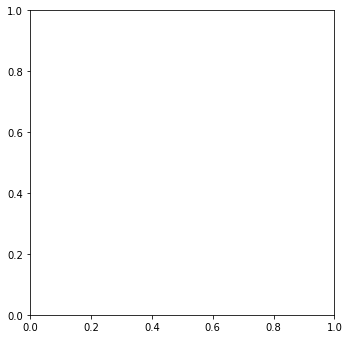

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)

In [8]:
print("shqhin")

shqhin
